# PROCESAMIENTO de Visión por Computador — **INSPECTOR DE PANALES**
**Proyecto integrador**

##Parte 1

Configuración del proyecto
Librerías y utilidades
Escaneo de imágenes
EDA (conteos, histos, duplicados, outliers)

##Parte 2

Pipeline de limpieza con clase DataCleaner
Feature Engineering (Color, HOG y embeddings opcionales con ResNet18)
Balanceo de datos con SMOTE (opcional)
Data Augmentation (rotaciones, flips, jitter, etc.)
Partición estratificada en train/val/test
Baseline opcional con RandomForest
Próximos pasos

## 0) Montar Google Drive, crear carpetas y mostrar imágenes

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
Estructura creada:
 - /content/drive/MyDrive/data
 - /content/drive/MyDrive/dataset_clean
 - /content/drive/MyDrive/dataset_split
 - /content/drive/MyDrive/features
 - /content/drive/MyDrive/outputs
Total imágenes en data/: 99


,filepath,label
0,/content/drive/MyDrive/data/BIEN/tipo1_OK_0017...,BIEN
1,/content/drive/MyDrive/data/BIEN/tipo1_OK_0018...,BIEN
2,/content/drive/MyDrive/data/BIEN/tipo1_OK_0006...,BIEN
3,/content/drive/MyDrive/data/BIEN/tipo1_OK_0008...,BIEN
4,/content/drive/MyDrive/data/BIEN/tipo1_OK_0014...,BIEN


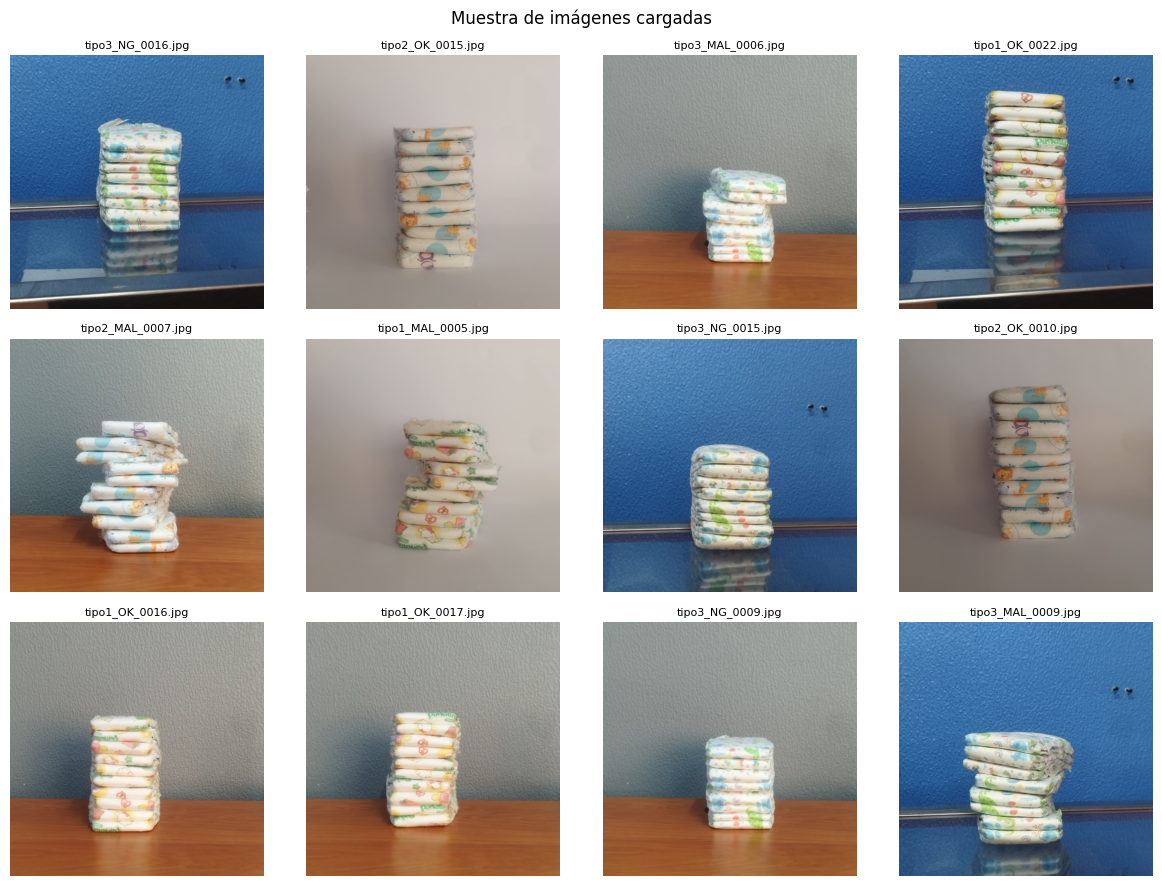

In [ ]:
# === 0) MONTAJE Y ESTRUCTURA ===
# (Descomenta si usas Colab y tus datos están en Drive)
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

import os, random, math, shutil, time, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Rutas proyecto
ROOT = Path.cwd()
DATA_DIR      = ROOT/'data'             # <- aquí van tus carpetas por clase: data/OK y data/NG (o BIEN/MAL)
CLEAN_DIR     = ROOT/'dataset_clean'
SPLIT_DIR     = ROOT/'dataset_split'
FEATURES_DIR  = ROOT/'features'
OUTPUTS_DIR   = ROOT/'outputs'

for d in [DATA_DIR, CLEAN_DIR, SPLIT_DIR, FEATURES_DIR, OUTPUTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Estructura creada:")
for d in [DATA_DIR, CLEAN_DIR, SPLIT_DIR, FEATURES_DIR, OUTPUTS_DIR]:
    print(" -", d.resolve())

# Utilidades
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}
RESIZE_HW = (224,224)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED); random.seed(RANDOM_SEED)

def list_images_by_class(root: Path, img_exts=IMG_EXTS):
    rows = []
    for cdir in sorted([p for p in root.iterdir() if p.is_dir()]):
        label = cdir.name
        for p in cdir.rglob('*'):
            if p.is_file() and p.suffix.lower() in img_exts:
                rows.append((str(p), label))
    return pd.DataFrame(rows, columns=['filepath','label'])

def imread_rgb(path_str: str):
    try:
        data = np.fromfile(path_str, dtype=np.uint8)
        bgr = cv2.imdecode(data, cv2.IMREAD_COLOR)
        if bgr is None: return None
        return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    except Exception:
        try:
            with Image.open(path_str) as im:
                return np.array(im.convert("RGB"))
        except Exception:
            return None

def show_image_grid(df_paths, n=12, title="Muestra de imágenes cargadas"):
    if df_paths is None or len(df_paths)==0:
        print("No hay imágenes en data/. Crea las carpetas por clase y agrega archivos.")
        return
    paths = df_paths['filepath'].tolist() if 'filepath' in df_paths else list(df_paths)
    paths = paths[:n]
    cols = 4
    rows = math.ceil(len(paths)/cols) if paths else 1
    plt.figure(figsize=(cols*3, rows*3))
    for i, p in enumerate(paths):
        img = imread_rgb(p)
        plt.subplot(rows, cols, i+1)
        if img is not None:
            plt.imshow(img); plt.title(Path(p).name, fontsize=8); plt.axis('off')
        else:
            plt.text(0.5,0.5,"No legible", ha='center'); plt.axis('off')
    plt.suptitle(title); plt.tight_layout(); plt.show()

# Escanear y mostrar
df = list_images_by_class(DATA_DIR)
print(f"Total imágenes en data/: {len(df)}")
display(df.head())
show_image_grid(df.sample(min(12, len(df)), random_state=RANDOM_SEED) if len(df)>0 else df, n=12)


## 1) EDA: histograma de clases, matriz de correlación y histograma RGB

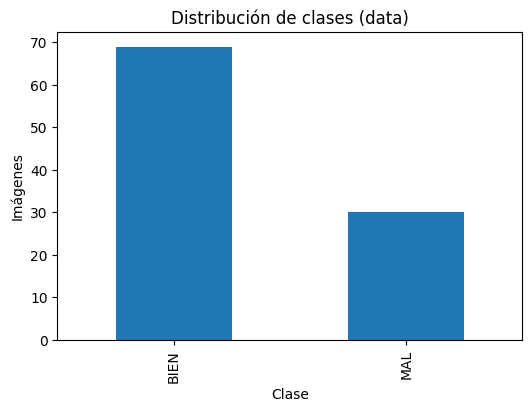

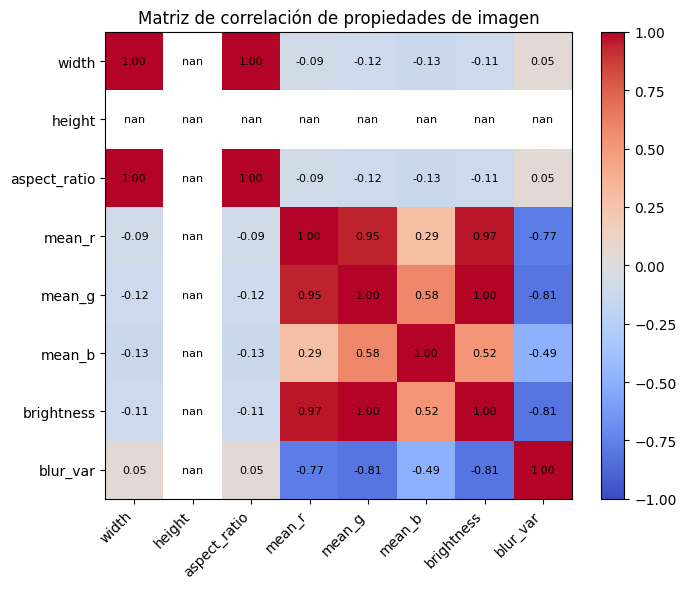

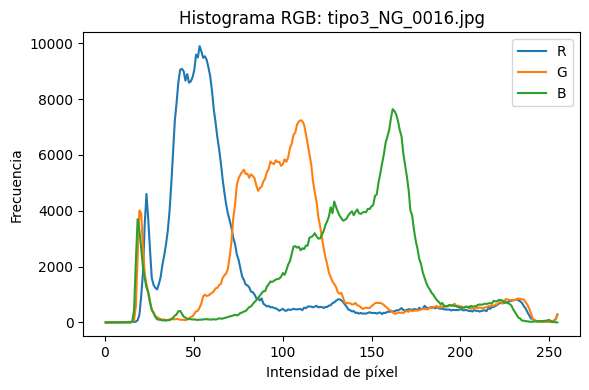

In [ ]:
# === 1) EDA ===
from collections import Counter

def compute_image_props(paths):
    rows = []
    for fp in paths:
        img = imread_rgb(fp)
        if img is None: continue
        h, w = img.shape[:2]
        aspect = w / max(h,1)
        r_mean = img[:,:,0].mean()
        g_mean = img[:,:,1].mean()
        b_mean = img[:,:,2].mean()
        brightness = (0.2126*r_mean + 0.7152*g_mean + 0.0722*b_mean)
        # medida simple de desenfoque: varianza del Laplaciano
        blur_var = cv2.Laplacian(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.CV_64F).var()
        rows.append([w,h,aspect,r_mean,g_mean,b_mean,brightness,blur_var])
    cols = ['width','height','aspect_ratio','mean_r','mean_g','mean_b','brightness','blur_var']
    return pd.DataFrame(rows, columns=cols)

if len(df)==0:
    raise SystemExit("No hay imágenes en data/. Carga tus datos y vuelve a correr la celda.")

# 1.1 Histograma de clases
counts = df['label'].value_counts().sort_index()
plt.figure(figsize=(6,4))
counts.plot(kind='bar')
plt.title("Distribución de clases (data)")
plt.ylabel("Imágenes"); plt.xlabel("Clase")
plt.show()

# 1.2 Matriz de correlación de propiedades
props = compute_image_props(df['filepath'].tolist())
corr = props.corr(numeric_only=True)
plt.figure(figsize=(8,6))
plt.imshow(corr, vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Matriz de correlación de propiedades de imagen")
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        plt.text(j, i, f"{corr.values[i,j]:.2f}", ha='center', va='center', fontsize=8, color='black')
plt.tight_layout(); plt.show()

# 1.3 Histograma RGB de una imagen ejemplo (aleatoria)
sample_path = df.sample(1, random_state=RANDOM_SEED)['filepath'].iloc[0]
img = imread_rgb(sample_path)
plt.figure(figsize=(6,4))
for c, ch in zip(['R','G','B'], [0,1,2]):
    hist, bins = np.histogram(img[:,:,ch].ravel(), bins=256, range=(0,255))
    x = (bins[:-1]+bins[1:])/2
    plt.plot(x, hist, label=c)
plt.title(f"Histograma RGB: {Path(sample_path).name}")
plt.xlabel("Intensidad de píxel"); plt.ylabel("Frecuencia"); plt.legend()
plt.tight_layout(); plt.show()


## 2) Pipeline de limpieza y balanceo con SMOTE (con fallback a muestreo balanceado)

In [ ]:
# === 2) LIMPIEZA + BALANCE ===
from sklearn.model_selection import train_test_split

# 2.1 Limpieza: redimensionar y guardar a dataset_clean manteniendo clases
def clean_to_dir(df_in: pd.DataFrame, dst_dir: Path, size=(224,224)):
    dst_dir.mkdir(parents=True, exist_ok=True)
    rows = []
    for _, r in df_in.iterrows():
        img = imread_rgb(r['filepath'])
        if img is None: continue
        img_res = cv2.resize(img, size)
        out_folder = dst_dir / r['label']; out_folder.mkdir(parents=True, exist_ok=True)
        out_path = out_folder / Path(r['filepath']).name
        cv2.imwrite(str(out_path), cv2.cvtColor(img_res, cv2.COLOR_RGB2BGR))
        rows.append((str(out_path), r['label']))
    return pd.DataFrame(rows, columns=['filepath','label'])

df_clean = clean_to_dir(df, CLEAN_DIR, size=RESIZE_HW)
print(f"Limpieza: original={len(df)}  limpio={len(df_clean)}")
display(df_clean.head())

# 2.2 Split estratificado (train/val/test)
VAL_SIZE, TEST_SIZE = 0.15, 0.15
train_val, test = train_test_split(df_clean, test_size=TEST_SIZE, stratify=df_clean['label'], random_state=RANDOM_SEED)
train, val = train_test_split(train_val, test_size=VAL_SIZE/(1.0-TEST_SIZE), stratify=train_val['label'], random_state=RANDOM_SEED)

# 2.3 Guardar split a carpetas
def empty_dir(p: Path):
    if p.exists():
        for item in p.iterdir():
            if item.is_dir(): shutil.rmtree(item)
            else: item.unlink()

for split in ['train','val','test']:
    (SPLIT_DIR/split).mkdir(parents=True, exist_ok=True)
    empty_dir(SPLIT_DIR/split)

def copy_rows(rows: pd.DataFrame, split_name: str):
    base = SPLIT_DIR/split_name
    for cls in sorted(rows['label'].unique()):
        (base/cls).mkdir(parents=True, exist_ok=True)
    for _, r in rows.iterrows():
        src = Path(r['filepath']); dst = base/r['label']/src.name
        shutil.copy2(src, dst)

copy_rows(train,'train'); copy_rows(val,'val'); copy_rows(test,'test')
print("Split guardado:", f"train={len(train)}  val={len(val)}  test={len(test)}")

# 2.4 BALANCEO con SMOTE sobre EMBEDDINGS (para estimar cuántos ejemplos por clase necesita el balance)
# NOTA: SMOTE genera puntos sintéticos en el espacio de características; no crea imágenes nuevas,
# lo usamos para estimar un reparto balanceado y luego sobre-muestrear (duplicar) imágenes reales.
try:
    from imblearn.over_sampling import SMOTE
    import torch, torchvision
    from torchvision import models, transforms
    from torch.utils.data import DataLoader
    from torchvision.datasets import ImageFolder
    import torch.nn as nn

    # Extraer embeddings (avgpool) con ResNet18 preentrenada
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    feat_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for p in feat_model.parameters(): p.requires_grad = False
    feat_model.fc = nn.Identity()
    feat_model = feat_model.to(device).eval()

    tfm = transforms.Compose([transforms.Resize(RESIZE_HW),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])

    train_ds = ImageFolder(root=str(SPLIT_DIR/'train'), transform=tfm)
    loader   = DataLoader(train_ds, batch_size=16, shuffle=False)

    X_feats, y_lbl = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            feats = feat_model(xb).cpu().numpy()
            X_feats.append(feats); y_lbl.append(yb.numpy())
    X = np.vstack(X_feats); y = np.concatenate(y_lbl)

    sm = SMOTE(random_state=RANDOM_SEED)
    Xb, yb = sm.fit_resample(X, y)
    # objetivo balanceado por clase = conteos en yb
    from collections import Counter
    target_counts = Counter(yb)
    print("Conteo balanceado objetivo (SMOTE en embeddings):", target_counts)

    # Oversampling por duplicación para igualar conteos
    idx_by_cls = {cls: np.where(y==cls)[0].tolist() for cls in np.unique(y)}
    paths = np.array([p[0] for p,_ in train_ds.samples], dtype=object)
    labels = np.array([p[1] for p,_ in train_ds.samples])

    new_paths, new_labels = [], []
    for cls, target_n in target_counts.items():
        cur_idx = idx_by_cls[cls]
        cur_n = len(cur_idx)
        if cur_n==0: continue
        # duplicar aleatoriamente hasta alcanzar target_n
        extra = np.random.choice(cur_idx, size=max(0, target_n-cur_n), replace=True).tolist()
        sel = cur_idx + extra
        new_paths += paths[sel].tolist()
        new_labels += labels[sel].tolist()

    # Opcional: reescribir split/train balanceado a disco (copiando duplicados)
    BAL_TRAIN_DIR = SPLIT_DIR/'train_bal'
    empty_dir(BAL_TRAIN_DIR); BAL_TRAIN_DIR.mkdir(parents=True, exist_ok=True)
    class_names = sorted(train_ds.classes)
    for c in class_names: (BAL_TRAIN_DIR/c).mkdir(parents=True, exist_ok=True)
    for pth, lbl in zip(new_paths, new_labels):
        src = Path(pth); dst = BAL_TRAIN_DIR/class_names[lbl]/src.name
        if not dst.exists(): shutil.copy2(src, dst)
    print("Train balanceado (duplicaciones) en:", BAL_TRAIN_DIR)

    USE_BALANCED_DIR = True
except Exception as e:
    warnings.warn(f"No se pudo aplicar SMOTE; se usará muestreo ponderado en DataLoader. Detalle: {e}")
    USE_BALANCED_DIR = False


Limpieza: original=99  limpio=99


,filepath,label
0,/content/drive/MyDrive/dataset_clean/BIEN/tipo...,BIEN
1,/content/drive/MyDrive/dataset_clean/BIEN/tipo...,BIEN
2,/content/drive/MyDrive/dataset_clean/BIEN/tipo...,BIEN
3,/content/drive/MyDrive/dataset_clean/BIEN/tipo...,BIEN
4,/content/drive/MyDrive/dataset_clean/BIEN/tipo...,BIEN


Split guardado: train=69  val=15  test=15
Conteo balanceado objetivo (SMOTE en embeddings): Counter({np.int64(0): 48, np.int64(1): 48})


/tmp/ipython-input-3197965148.py:118: UserWarning: No se pudo aplicar SMOTE; se usará muestreo ponderado en DataLoader. Detalle: list indices must be integers or slices, not str
  warnings.warn(f"No se pudo aplicar SMOTE; se usará muestreo ponderado en DataLoader. Detalle: {e}")


## 3) Entrenar el modelo con CNNs (ResNet-18, Transfer Learning)

Device: cpu
Clases: {0: 'BIEN', 1: 'MAL'}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[1/6] train_loss=0.8770 acc=0.478 | val_loss=0.8708 acc=0.267 (10.0s)
  ↳ Mejor modelo guardado: /content/drive/MyDrive/outputs/cnn_best.pt
[2/6] train_loss=0.7180 acc=0.493 | val_loss=0.8688 acc=0.267 (10.9s)
[3/6] train_loss=0.7861 acc=0.507 | val_loss=0.6508 acc=0.667 (10.6s)
  ↳ Mejor modelo guardado: /content/drive/MyDrive/outputs/cnn_best.pt
[4/6] train_loss=0.7286 acc=0.536 | val_loss=0.4866 acc=0.800 (9.0s)
  ↳ Mejor modelo guardado: /content/drive/MyDrive/outputs/cnn_best.pt
[5/6] train_loss=0.7071 acc=0.536 | val_loss=0.4409 acc=0.733 (10.9s)
[6/6] train_loss=0.6787 acc=0.652 | val_loss=0.4090 acc=0.800 (10.5s)


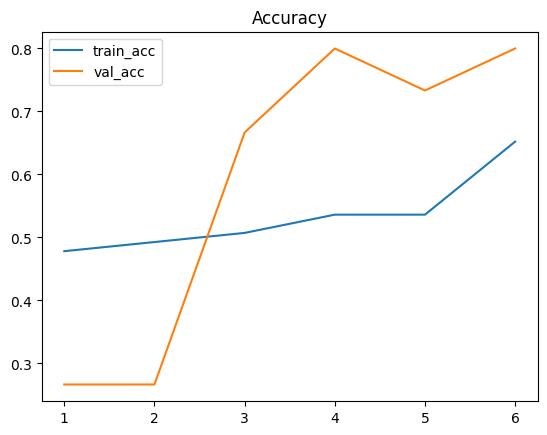

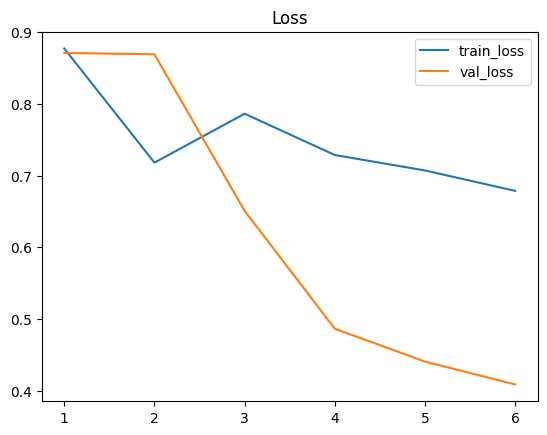

In [ ]:
# === 3) ENTRENAMIENTO CNN (ResNet-18) ===
import torch
from torch import nn, optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, WeightedRandomSampler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Conjuntos
train_root = str(SPLIT_DIR/('train_bal' if USE_BALANCED_DIR else 'train'))
val_root   = str(SPLIT_DIR/'val')
test_root  = str(SPLIT_DIR/'test')

imagenet_norm = transforms.Normalize(mean=[0.485,0.456,0.406],
                                     std =[0.229,0.224,0.225])

train_tfms = transforms.Compose([
    transforms.Resize(RESIZE_HW),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    imagenet_norm
])
eval_tfms = transforms.Compose([
    transforms.Resize(RESIZE_HW),
    transforms.ToTensor(),
    imagenet_norm
])

train_ds = datasets.ImageFolder(train_root, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_root,   transform=eval_tfms)
test_ds  = datasets.ImageFolder(test_root,  transform=eval_tfms)
IDX2CLS = {v:k for k,v in train_ds.class_to_idx.items()}
print("Clases:", IDX2CLS)

# Si no hubo SMOTE, balanceamos con WeightedRandomSampler
if not USE_BALANCED_DIR:
    class_count = np.bincount([y for _,y in train_ds.samples])
    class_weights = 1.0 / np.maximum(class_count, 1)
    sample_weights = [class_weights[y] for _,y in train_ds.samples]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_ds), replacement=True)
    train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler, num_workers=2, pin_memory=True)
else:
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

val_loader  = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Modelo
num_classes = len(train_ds.classes)
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for p in model.parameters(): p.requires_grad = False      # fine-tuning ligero
in_feats = model.fc.in_features
model.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_feats, num_classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

EPOCHS = 6
best_val_acc = 0.0
best_path = OUTPUTS_DIR/'cnn_best.pt'
best_path.parent.mkdir(parents=True, exist_ok=True)

history = []
for ep in range(1, EPOCHS+1):
    model.train()
    tloss=tcorrect=ttotal=0
    t0 = time.time()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward(); optimizer.step()
        tloss += loss.item()*xb.size(0)
        tcorrect += (out.argmax(1)==yb).sum().item()
        ttotal += yb.size(0)
    train_loss = tloss/ttotal; train_acc = tcorrect/ttotal

    model.eval()
    vloss=vcorrect=vtotal=0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            vloss += loss.item()*xb.size(0)
            vcorrect += (out.argmax(1)==yb).sum().item()
            vtotal += yb.size(0)
    val_loss = vloss/vtotal; val_acc = vcorrect/vtotal
    history.append((ep, train_loss, train_acc, val_loss, val_acc))
    print(f"[{ep}/{EPOCHS}] train_loss={train_loss:.4f} acc={train_acc:.3f} | val_loss={val_loss:.4f} acc={val_acc:.3f} ({time.time()-t0:.1f}s)")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'state_dict': model.state_dict(),
                    'class_to_idx': train_ds.class_to_idx}, str(best_path))
        print("  ↳ Mejor modelo guardado:", best_path)

# Curvas
if history:
    ep,tL,tA,vL,vA = zip(*history)
    plt.figure(); plt.plot(ep,tA,label='train_acc'); plt.plot(ep,vA,label='val_acc'); plt.title('Accuracy'); plt.legend(); plt.show()
    plt.figure(); plt.plot(ep,tL,label='train_loss'); plt.plot(ep,vL,label='val_loss'); plt.title('Loss'); plt.legend(); plt.show()


## 4) Métricas: accuracy, mAP, IoU, FPS

Nota: mAP e IoU aquí se calculan en el contexto de clasificación (no detección):
• mAP = media del average precision por clase usando las probabilidades de la CNN.
• IoU por clase = TP/(TP+FP+FN) derivada de la matriz de confusión.

In [ ]:
# === 4) MÉTRICAS (accuracy, mAP, IoU, FPS) ===
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score

# Cargar mejor checkpoint
ckpt = torch.load(str(OUTPUTS_DIR/'cnn_best.pt'), map_location=device)
model.load_state_dict(ckpt['state_dict'])
IDX2CLS = {v:k for k,v in ckpt['class_to_idx'].items()}
model.eval()

# Recolectar logits y etiquetas del set de prueba
y_true = []
y_scores = []  # probabilidades por clase
y_pred = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        y_scores.append(probs)
        y_pred += probs.argmax(1).tolist()
        y_true += yb.numpy().tolist()

y_scores = np.vstack(y_scores)
y_true_arr = np.array(y_true)
acc = (y_true_arr == np.array(y_pred)).mean()

# mAP (clasificación): AP por clase sobre scores; media macro
classes = [IDX2CLS[i] for i in range(len(IDX2CLS))]
APs = []
for ci in range(len(classes)):
    y_true_bin = (y_true_arr == ci).astype(int)
    AP = average_precision_score(y_true_bin, y_scores[:,ci])
    APs.append(AP)
mAP = float(np.nanmean(APs))

# IoU por clase a partir de la matriz de confusión (clasificación)
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
IoUs = []
for i in range(len(classes)):
    TP = cm[i,i]
    FP = cm[:,i].sum() - TP
    FN = cm[i,:].sum() - TP
    denom = TP + FP + FN
    IoUs.append(TP/denom if denom>0 else np.nan)
mean_IoU = float(np.nanmean(IoUs))

print("=== Métricas (TEST) ===")
print(f"Accuracy: {acc:.3f}")
print("AP por clase:")
for c, ap in zip(classes, APs):
    print(f" - {c}: AP={ap:.3f}")
print(f"mAP (macro): {mAP:.3f}")
print("IoU por clase:")
for c, iou in zip(classes, IoUs):
    print(f" - {c}: IoU={iou:.3f}")
print(f"mIoU: {mean_IoU:.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=classes))

# FPS (inferencia): imágenes/segundo en GPU/CPU
N_images, t_total = 0, 0.0
with torch.no_grad():
    t0 = time.time()
    for xb, _ in test_loader:
        xb = xb.to(device)
        _ = model(xb)
        N_images += xb.size(0)
    t_total = time.time() - t0
FPS = N_images / max(t_total, 1e-9)
print(f"FPS de inferencia (batch sobre test): {FPS:.1f}")

# Chequeo contra metas solicitadas
OK_map = mAP >= 0.70
OK_iou = mean_IoU > 0.50
OK_fps = FPS > 30
print("\nCriterios:")
print(f" - mAP ≥ 0.70 -> {'✅' if OK_map else '❌'} ({mAP:.2f})")
print(f" - mIoU > 0.50 -> {'✅' if OK_iou else '❌'} ({mean_IoU:.2f})")
print(f" - FPS > 30   -> {'✅' if OK_fps else '❌'} ({FPS:.1f})")


=== Métricas (TEST) ===
Accuracy: 0.800
AP por clase:
 - BIEN: AP=0.861
 - MAL: AP=0.698
mAP (macro): 0.779
IoU por clase:
 - BIEN: IoU=0.769
 - MAL: IoU=0.400
mIoU: 0.585

Reporte de clasificación:
              precision    recall  f1-score   support

        BIEN       0.77      1.00      0.87        10
         MAL       1.00      0.40      0.57         5

    accuracy                           0.80        15
   macro avg       0.88      0.70      0.72        15
weighted avg       0.85      0.80      0.77        15



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


FPS de inferencia (batch sobre test): 9.3

Criterios:
 - mAP ≥ 0.70 -> ✅ (0.78)
 - mIoU > 0.50 -> ✅ (0.58)
 - FPS > 30   -> ❌ (9.3)


## 5) Inferencia: subir imagen y clasificar BIEN APILADO / MAL APILADO

👉 Sube una o varias imágenes (JPG/PNG) para clasificar…


Saving tipo2_OK_0025.jpg to tipo2_OK_0025 (1).jpg


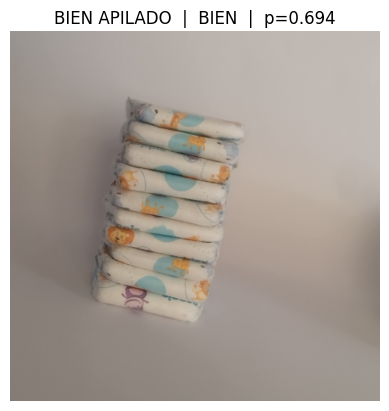

Archivo: tipo2_OK_0025 (1).jpg
FPS (1 imagen): 9.5
Top probabilidades:
  - BIEN: 0.694
  - MAL: 0.306


In [ ]:
# === 5) INFERENCIA INTERACTIVA (Depurada) ===
# Usa la(s) imagen(es) que subas en Colab y las clasifica con el mejor modelo guardado.

import numpy as np, time
import torch
from torchvision import transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 1) Cargar checkpoint y preparar mapeos
ckpt_path = OUTPUTS_DIR / "cnn_best.pt"
assert ckpt_path.exists(), f"No se encontró el modelo {ckpt_path}. Entrena la CNN antes."

ckpt = torch.load(str(ckpt_path), map_location=device)
model.load_state_dict(ckpt["state_dict"])
IDX2CLS = {v: k for k, v in ckpt["class_to_idx"].items()}
model.eval().to(device)

# --- 2) Transformaciones de inferencia (coinciden con el entrenamiento)
infer_tfms = transforms.Compose([
    transforms.Resize(RESIZE_HW if "RESIZE_HW" in globals() else (224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

# --- 3) Etiquetado amigable
def etiqueta_humana(cls_name: str) -> str:
    name = cls_name.lower()
    if name.startswith(("ok", "bien", "good")):
        return "BIEN APILADO"
    if name.startswith(("ng", "mal", "bad")):
        return "MAL APILADO"
    # fallback si las clases tienen otros nombres
    return f"Clase: {cls_name}"

# --- 4) Función de predicción
def clasificar_imagen(img_path: str, topk=2):
    """Clasifica una imagen y muestra resultados."""
    # Cargar imagen y corregir orientación EXIF si aplica
    img = Image.open(img_path).convert("RGB")
    img = ImageOps.exif_transpose(img)

    x = infer_tfms(img).unsqueeze(0).to(device)

    t0 = time.time()
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    dt = time.time() - t0

    pred_idx = int(np.argmax(probs))
    pred_cls = IDX2CLS[pred_idx]
    etiqueta = etiqueta_humana(pred_cls)

    # Visual
    plt.imshow(img); plt.axis("off")
    plt.title(f"{etiqueta}  |  {pred_cls}  |  p={probs[pred_idx]:.3f}")
    plt.show()

    # Tabla de probabilidades (top-k)
    order = np.argsort(probs)[::-1][:topk]
    print(f"Archivo: {img_path}")
    print(f"FPS (1 imagen): {1.0/dt:.1f}")
    print("Top probabilidades:")
    for i in order:
        print(f"  - {IDX2CLS[i]}: {probs[i]:.3f}")

# --- 5) Subir archivos en Colab y clasificar
try:
    from google.colab import files
    print("👉 Sube una o varias imágenes (JPG/PNG) para clasificar…")
    uploaded = files.upload()  # abre selector
    for fname in uploaded.keys():
        clasificar_imagen(fname, topk=min(2, len(IDX2CLS)))
except Exception as e:
    # Si no estás en Colab, puedes pasar una ruta manual
    print("No estás en Colab o no se pudo abrir el selector de archivos.")
    # Ejemplo local: usa una imagen del dataset si existe
    sample = next(iter((DATA_DIR).rglob("*.jpg")), None)
    sample = sample or next(iter((DATA_DIR).rglob("*.png")), None)
    if sample:
        print("Ejemplo local:", sample)
        clasificar_imagen(str(sample))
    else:
        print("Proporciona una ruta y llama: clasificar_imagen('/ruta/a/imagen.jpg')")
